In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops

import helper_functions.displayFunctions as display

# Extracting background

We begin by extracting the image and the mask of the segment from the bounding box.

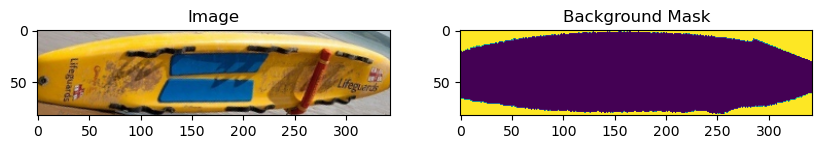

In [12]:
boxes = pd.read_csv('data/experiment_boxes.csv')
od_matches = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)
row = od_matches.iloc[80]

with open('predictions/saved_predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

# Loading image and mask
box_row = boxes.iloc[int(row['box_id'])]
img_orig = cv2.cvtColor(cv2.imread(display.getImgPath(box_row['file_name'])), cv2.COLOR_BGR2RGB)
mask = predictions[box_row['file_name']].masks[row['match_id']].data.cpu().numpy()[0]
mask = cv2.resize(mask, (predictions[box_row['file_name']].orig_shape[1], predictions[box_row['file_name']].orig_shape[0]))

# Cropping image and mask
mask = display.crop_image(mask, box_row)
img = display.crop_image(img_orig, box_row)

# Inverting mask
mask = np.where(mask == 0, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(mask)
axes[1].set_title('Background Mask')

plt.show()

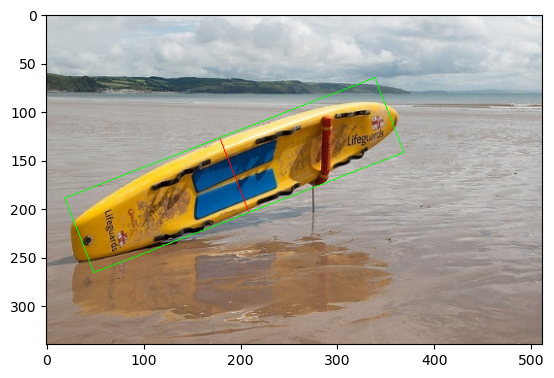

In [10]:
display.drawBB(img_orig, box_row)

plt.imshow(img_orig)

# Homogeneity metrics

## Gray-Level Co-occurrence Matrix (GLCM)

We'll be calculating Homogeneity of the resulting pixels of the user indicated box after removing the detected segment from it. We will be using Gray-Level Co-occurrence Matrix (GLCM) Homogeneity. The GLCM is a statistical method that considers pixel pairs and calculates texture features. To measure homogeneity, the matrix emphasizes the presence of pixels with similar intensities.

* First, compute the GLCM of the image at various directions (e.g., 0°, 45°, 90°, and 135°).
* Then, calculate homogeneity as:
$$
\text{Homogeneity} = \sum_{i,j} \frac{P(i, j)}{1 + |i - j|}
$$
where $P(i,j)$ is the GLCM matrix value at position $(i,j)$.

In [4]:
def glcm(img_color: np.ndarray, mask: np.ndarray) -> float:
    """
    Computes the Gray Level Co-occurrence Matrix (GLCM) and calculates the homogeneity of the given image within the specified mask.
    Parameters:
    img_color (numpy.ndarray): The input color image in RGB format.
    mask (numpy.ndarray): The binary mask to apply to the image. Should be the same size as img_color.
    Returns:
    float: The mean homogeneity value computed from the GLCM.
    """
    # Greyscale image
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Apply the mask to the grayscale image and normalize
    masked_image = img * mask
    masked_image_uint8 = (masked_image * 255).astype(np.uint8)
    masked_pixels = masked_image_uint8[mask == 1]

    # Compute GLCM on masked pixels (reshape for GLCM input)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(masked_pixels.reshape(-1, 1), distances, angles, levels=256, symmetric=True, normed=True)

    # Calculate homogeneity
    homogeneity = graycoprops(glcm, 'homogeneity')
    return homogeneity.mean()

print("GLCM:",glcm(img, mask))

GLCM: 0.071897058338205


## Otsu's Method

Otsu's Method is used to perform automatic image thresholding. In the simplest form, the algorithm returns a single intensity threshold that separate pixels into two classes, foreground and background.

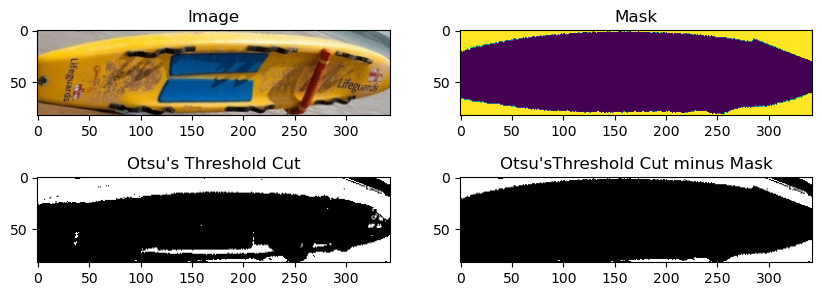

In [5]:
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

_, threshold = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

threshold_cut = display.crop_image(threshold, box_row)
threshold_cut_mask = threshold_cut * mask


fig, axes = plt.subplots(2, 2, figsize=(10, 3.5))

axes[0, 0].imshow(img)
axes[0, 0].set_title('Image')
axes[0, 1].imshow(mask)
axes[0, 1].set_title('Mask')
axes[1, 0].imshow(threshold_cut, cmap='gray')
axes[1, 0].set_title('Otsu\'s Threshold Cut')
axes[1, 1].imshow(threshold_cut_mask, cmap='gray')
axes[1, 1].set_title('Otsu\'sThreshold Cut minus Mask')

plt.show()

In [6]:
def otsus_method(img_orig: np.ndarray, mask: np.ndarray, row: pd.core.series.Series) -> float:
    """
    Applies Otsu's thresholding method to an image and calculates the percentage of background within a masked region.
    Parameters:
    img_orig (np.ndarray): The original image in BGR format.
    mask (np.ndarray): A binary mask where the region of interest is marked.
    row (pd.core.series.Series): A pandas Series containing the coordinates for cropping the image.
    Returns:
    float: The percentage of background within the masked region.
    """

    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    threshold_cut = display.crop_image(threshold, row)

    # Apply the mask to the thresholded image
    threshold_cut_mask = threshold_cut * mask

    percentage_of_background = np.sum(threshold_cut_mask) / np.sum(mask)

    return percentage_of_background

print("Otsus method's percentage of background", otsus_method(img_orig, mask, box_row))

Otsus method's percentage of background 0.7190707725553754


## Root Mean Squared (RMS)

Measure used in image processing and vision science to quantify the contrast within an image. It provides a single value that describes the overall contrast by examining the pixel intensity variations relative to the mean intensity. RMS contrast is particularly useful because it captures both high-contrast and low-contrast features, offering a robust sense of the contrast levels throughout the image.

The Root Mean Squared (RMS) contrast is calculated as:

$$
\text{RMS Contrast} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (I_i - \bar{I})^2}
$$

where:
- \( N \) is the total number of pixels in the image or the masked area,
- \( I_i \) is the intensity of the \(i\)-th pixel,
- \( \bar{I} \) is the mean intensity of the area.

In [7]:
def rms(img_color: np.ndarray, mask: np.ndarray) -> float:
    """
    Calculate the root mean square (RMS) contrast of a given image within a specified mask.
    Parameters:
    img_color (np.ndarray): The input color image in BGR format.
    mask (np.ndarray): A binary mask where the RMS contrast is to be calculated. 
                       The mask should have the same width and height as the input image.
    Returns:
    float: The RMS contrast value of the image within the masked region.
    """

    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    mean_intensity = np.mean(gray[mask == 1])
    rms_contrast = np.sqrt(np.mean((gray[mask == 1] - mean_intensity) ** 2))

    return rms_contrast

print("Root Mean Squared:",rms(img, mask))

Root Mean Squared: 42.56728516454071


## Complexity Metrics

### Edge density

Edge Density is a measure that quantifies the amount of edge information in an image relative to its total area. It indicates the complexity or texture within an image by evaluating the proportion of pixels that belong to edges, as detected by an edge detection algorithm (Canny edge detection).

$$
\text{Edge Density} = \frac{\text{Number of Edge Pixels}}{\text{Total Number of Pixels in the Image}}
$$

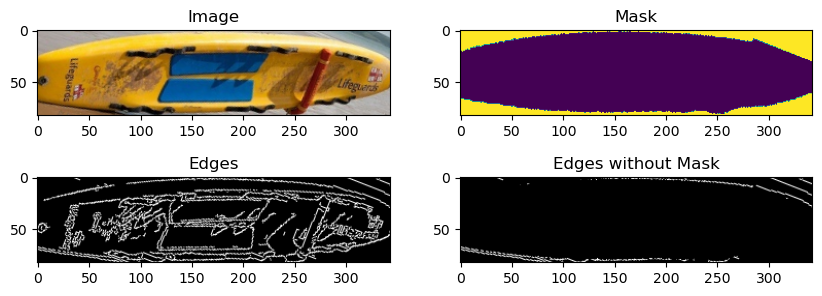

In [8]:
gray_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
edges_orig = cv2.Canny(gray_orig, 100, 200)
edges_orig_cut = display.crop_image(edges_orig, box_row)

edges_without_mask = edges_orig_cut * mask

fig, axes = plt.subplots(2, 2, figsize=(10, 3.5))
axes[0, 0].imshow(img)
axes[0, 0].set_title('Image')
axes[0, 1].imshow(mask)
axes[0, 1].set_title('Mask')
axes[1, 0].imshow(edges_orig_cut, cmap='gray')
axes[1, 0].set_title('Edges')
axes[1, 1].imshow(edges_without_mask, cmap='gray')
axes[1, 1].set_title('Edges without Mask')

plt.show()

In [9]:
def edge_density(img_orig: np.ndarray, mask: np.ndarray, row: pd.core.series.Series, threshold1: int = 100, threshold2: int = 200) -> float:
    """
    Calculate the edge density of an image within a specified region of interest.
    Parameters:
    img_orig (np.ndarray): The original image in BGR format.
    mask (np.ndarray): A binary mask where the region of interest is marked with 1s and the rest with 0s.
    row (pd.core.series.Series): A pandas Series containing the coordinates for cropping the image.
    threshold1 (int, optional): The first threshold for the hysteresis procedure in Canny edge detection. Default is 100.
    threshold2 (int, optional): The second threshold for the hysteresis procedure in Canny edge detection. Default is 200.
    Returns:
    float: The edge density, calculated as the ratio of edge pixels to the total number of pixels in the masked region.
    """
    
    # Convert image to grayscale
    gray_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

    # Compute the Canny edge detection on the grayscale image
    edges_orig = cv2.Canny(gray_orig, 100, 200)
    edges_orig_cut = display.crop_image(edges_orig, row)
    edges = np.where(edges_orig_cut > 0, 1, 0)

    # Apply the mask to the edges
    edges = edges * mask

    # Calculate the edge density
    edge_density = np.sum(edges) / np.sum(mask)
    return edge_density

print("Edge Density:",edge_density(img_orig, mask, box_row))

Edge Density: 0.21429857734557897
